# 3. Podcast Listening Time - Final Analysis

We have done the Exploratory Data Analysis [Here](1_Podcast_EDA.ipynb), and ran our algorithms [Here](2_Podcast_ML.ipynb).

We can now connect the analysis to outcomes. This section explains what the model achieves and where it’s reliable. We summarize the key patterns uncovered during EDA, compare the final model's performance to the Kaggle Leaderboard, examine where predictions go wrong and analyze what could be the next steps do further improve our models.

In [49]:
import os, math, json, warnings, itertools, joblib, textwrap, requests
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display
from scipy import stats
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.stats.diagnostic import het_breuschpagan
from pathlib import Path
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn import set_config
set_config(transform_output="pandas") 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import rgb2hex
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

import shap
import fasttreeshap
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from functools import reduce
from dotenv import load_dotenv
from podcast_functions import *

print("Python:", sys.version.split()[0])
print("numpy:", numpy.__version__, "pandas:", pandas.__version__, "scikit-learn:", sklearn.__version__, "shap:", shap.__version__)

Python: 3.11.9
numpy: 1.26.4 pandas: 2.2.2 scikit-learn: 1.5.0 shap: 0.48.0


In [2]:
result_folder = "Results"
pred_folder   = os.path.join(result_folder, "predictions")
models_names = ["lgbm","xgb","cat","rf","nn","enet","knn","svr","hgb","et","ebm","tab"]

df_train = pd.read_csv("Data/train.csv")
df_test  = pd.read_csv("Data/test.csv")

target = "Listening_Time_minutes"
X_cat = ["Podcast_Name","Publication_Day","Publication_Time","Episode_Title","Episode_Sentiment"]
X_num = ["Episode_Length_minutes","Guest_Popularity_percentage","Number_of_Ads","Host_Popularity_percentage"]

for col in X_cat:
    df_train[col] = df_train[col].astype('category')
    df_test[col]  = df_test[col].astype('category')
      
X = df_train[X_cat + X_num]
y = df_train[target]

## 1. Model Performance

To make sure to have better and more reliable metrics of performance, we uploaded every prediction and we are going to pull and analyze our test RMSE of every single model we ran in the last notebook

In [4]:
kaggle_path = os.path.join(result_folder, f"kaggle_score.csv")
overwrite_ = False
load_dotenv() 

kaggle_perfs = get_kaggle_results(
    user = os.getenv("KAGGLE_USER"), 
    key = os.getenv("KAGGLE_KEY"), 
    path = kaggle_path,
    overwrite = overwrite_, 
    comp = "playground-series-s5e4", 
    models_names = models_names
)

# read the results from the last notebook
cv_results = pd.read_csv(os.path.join(result_folder, "cv_score.csv"), index_col = 0) 
cv_results.columns = ["cv_rmse","cv_r2"]

perfs = pd.merge(kaggle_perfs, cv_results, left_index=True, right_index=True, how='outer')
perfs = perfs.sort_values(by='publicScore',ascending=False)
perfs

,publicScore,privateScore,cv_rmse,cv_r2
enet,13.40409,13.30525,13.346651,0.758131
tab,13.38048,13.27398,13.255676,0.761417
nn,13.34133,13.23898,13.273978,0.760758
svr,13.30943,13.20972,13.266125,0.761041
ebm,13.10359,12.98379,13.074538,0.767893
hgb,13.07129,12.96525,13.010592,0.770158
cat,13.02853,12.90763,12.980260,0.771229
knn,12.95602,12.90736,12.995897,0.770677
xgb,12.75742,12.66001,12.738678,0.779665
lgbm,12.67323,12.58578,12.689524,0.781362


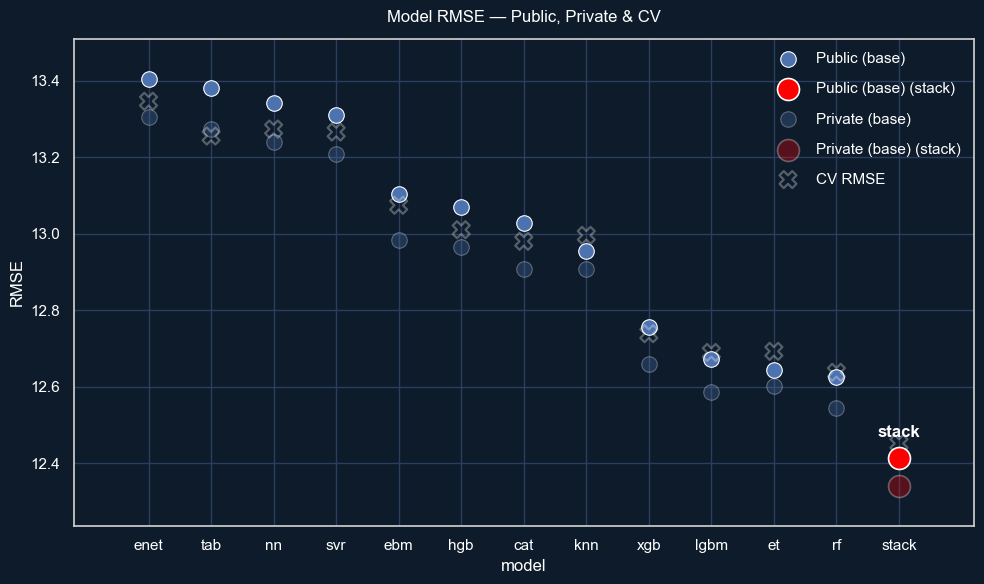

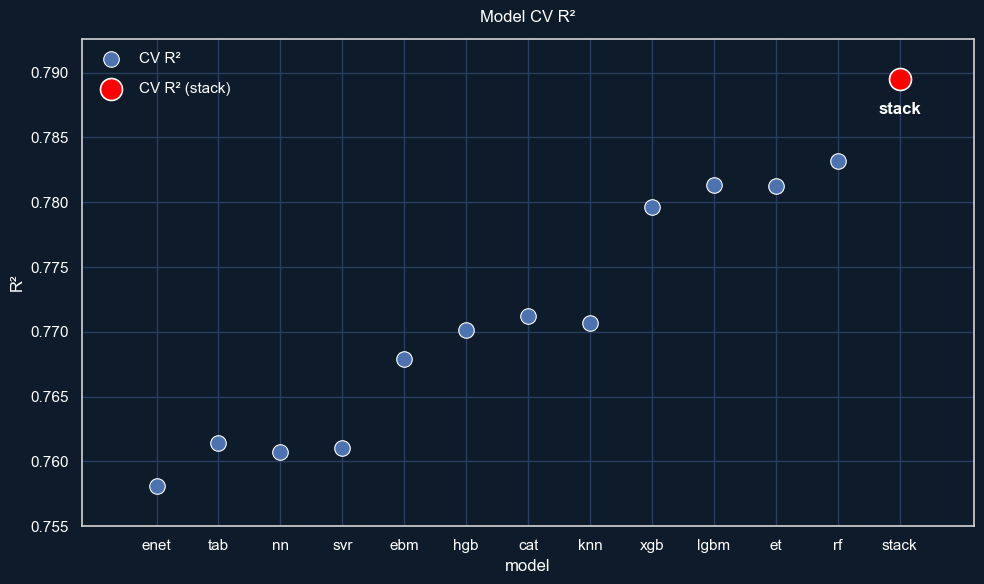

In [5]:
labels   = list(perfs.index)                           
public   = perfs["publicScore"].to_list()
private  = perfs["privateScore"].to_list()
cv_rmse  = perfs["cv_rmse"].to_list()
cv_r2    = perfs["cv_r2"].to_list()

plot_cv_rmse(labels, public, private, cv_rmse, stack_label="stack")
plot_cv_r2(labels, cv_r2, stack_label="stack")
plt.show()

From this post-model analysis, we conclude: 
- The private RMSE is always slightly lower than the public one for every model and the order of the performances are the mostly same whether it is for the public score or for the private score, which is a good sign, meaning that the prediction didn't overfit to the private sample.
- The order of the OOF CV RMSE is also very close to the Kaggle scores.
- The Final Stack estimator outperforms all the base models, which means that all the single models have values to bring and manage to capture information other models can't
- Bagging algorithms (Random Forest and Extra Trees) are the surprisingly the best single models. Some explanations might be that RF's averaging can be very resilient to label noise and high cardinality OHE. Boosters one the other hand can over-regularize and underfit some sparse but informative splits

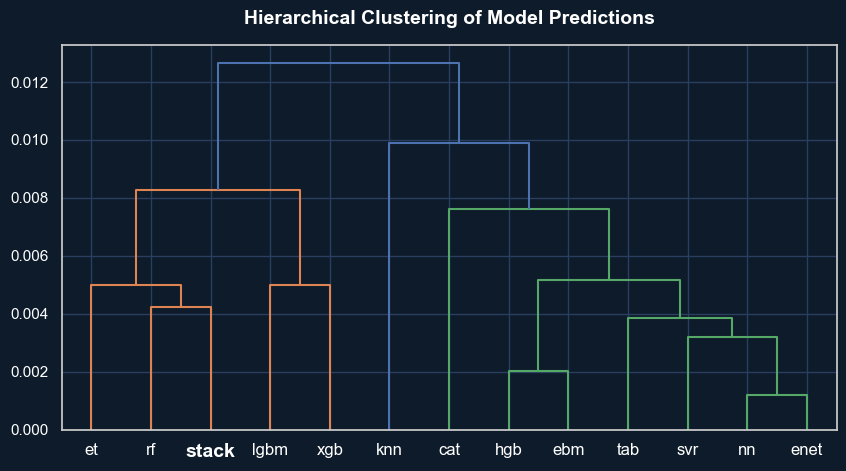

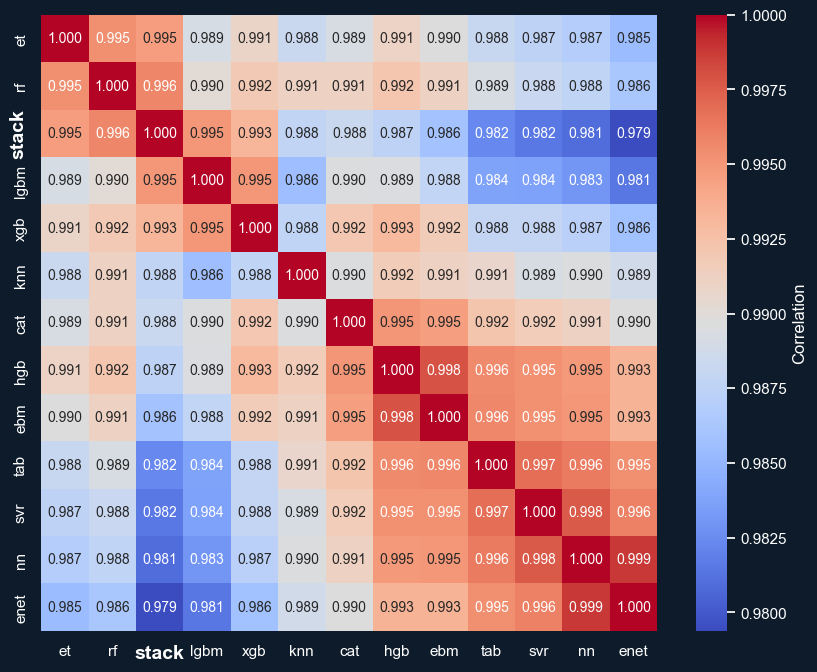

In [7]:
df_preds = []
models_with_stack = models_names + ["stack"]
for i in range(len(models_with_stack)):
    model = models_with_stack[i]
    df = pd.read_csv(os.path.join(result_folder, f"predictions_{model}.csv")) 
    df = df.rename(columns={'Listening_Time_minutes': model})
    df_preds.append(df)
df_preds = reduce(lambda left, right: pd.merge(left, right, on=left.columns[0]), df_preds)

# correlation + linkage
corr_matrix     = df_preds.iloc[:, 1:].corr()
distance_matrix = 1 - corr_matrix
linkage_matrix  = linkage(squareform(distance_matrix), method='average')

# dendrogram 
orig_labels = corr_matrix.index            
plt.figure(figsize=(10, 5))
ddata = dendrogram(linkage_matrix,labels=orig_labels,orientation="top")          

ax = plt.gca()
ax.set_title("Hierarchical Clustering of Model Predictions", fontsize=14,weight="bold", pad=15)
set_bold("stack", ax.get_xticklabels())  

# heat-map figure (uses the same row_order)
row_order = ddata['leaves']       
clustered_corr = corr_matrix.iloc[row_order, :].iloc[:, row_order]
plt.figure(figsize=(10, 8))
sns.heatmap(clustered_corr,cmap="coolwarm",annot=True, fmt=".3f",annot_kws={"size": 10},
            cbar_kws={'label': 'Correlation'},square=True,linewidths=0, linecolor='none')
set_bold("stack", plt.gca().get_xticklabels() + plt.gca().get_yticklabels())

We can note multiple observations from there :
- Predictions are highly correlated (lowest being 0.979) because the signal is concentrated and preprocessing is shared. With the same caps/imputation and mostly the same encodings, different learners end up modeling the same dominant structure, so their pointwise predictions co-move.
- Bagging and boosting each form tight clusters for structural reasons.
  - RF / ET: both are bagged, axis-aligned trees on OHE features; randomness (bootstrap vs. random thresholds) doesn’t change the core splits much.
  - LGB / XGB: both are histogram/leaf-wise gradient boosters optimizing squared error with similar regularization, so they learn similar partitions.
  - CatBoost / HGB often sit a bit apart because CatBoost uses ordered target stats and symmetric trees, and HGB consumes OHE with level-wise growth. Different categorical treatment led to slightly different partitions.
- The stack is most correlated with the bagging models because the meta-learner upweighted the best bases. It’s trained on OOF predictions to minimize CV RMSE; since RF/ET were the strongest single estimators here, their signals dominate the blend, pulling the stack closest to them.

## 2. Hyperparameters Search 

Let's analyze our best performing single-model RandomForest to better understand its hyperparameters. Tuning these parameters is essential for balancing complexity, generalization, and efficiency. In this section, we will review the search process, highlight the most influential parameters, and interpret their impact on the model’s performance.

In [8]:
models_names =  ["lgbm","xgb","cat","rf","nn","enet","knn","svr","hgb","et","ebm","tab"]
model_folder = os.path.join(result_folder, "models")
models = {model : joblib.load(os.path.join(model_folder, f"models_{model}.joblib")) for model in models_names}
best_estimators = {k: v.best_estimator_ for k, v in models.items()}

model_name = "rf"
search = models[model_name]
best = search.best_estimator_
model = best.named_steps[model_name]
pre  = best.named_steps["pre"]

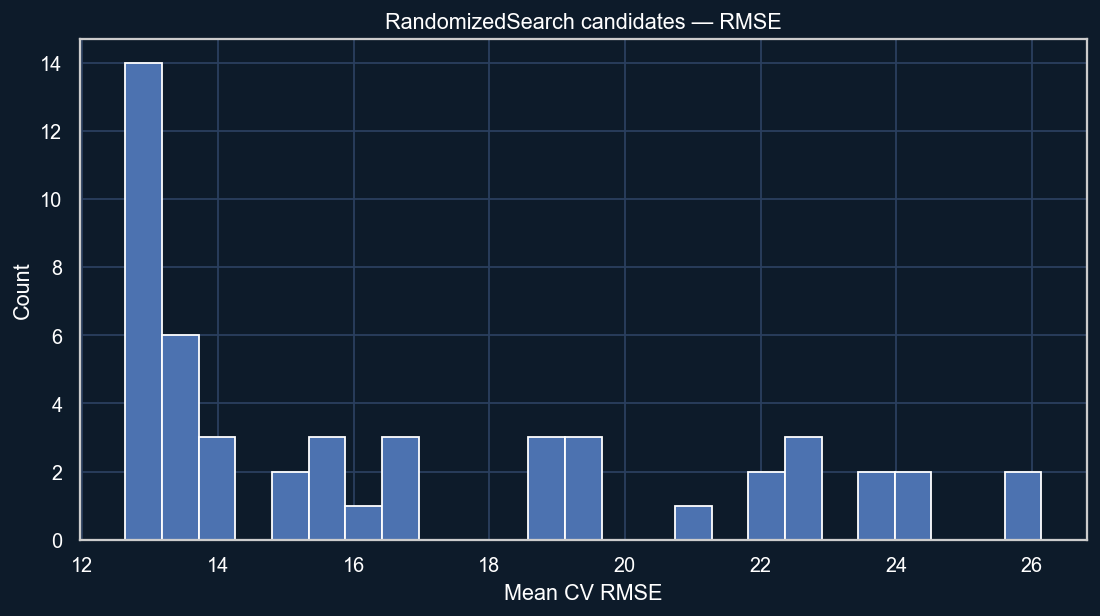

,rank_test_score,params,RMSE,std_test_score
47,1,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",12.637614,0.536628
49,2,"{'rf__n_estimators': 500, 'rf__min_samples_spl...",12.661777,0.618423
34,3,"{'rf__n_estimators': 500, 'rf__min_samples_spl...",12.669647,0.595393
45,4,"{'rf__n_estimators': 500, 'rf__min_samples_spl...",12.673462,0.589208
38,5,"{'rf__n_estimators': 500, 'rf__min_samples_spl...",12.674802,0.614934
2,6,"{'rf__n_estimators': 1000, 'rf__min_samples_sp...",12.730913,0.558273
28,7,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",12.780118,0.575327
35,8,"{'rf__n_estimators': 1000, 'rf__min_samples_sp...",12.851579,0.614401
41,9,"{'rf__n_estimators': 1000, 'rf__min_samples_sp...",12.929453,0.625945
8,10,"{'rf__n_estimators': 500, 'rf__min_samples_spl...",12.932364,0.637812


In [9]:
cv = pd.DataFrame(search.cv_results_).sort_values("rank_test_score")
cv["mean_rmse"] = np.sqrt(-cv["mean_test_score"])

plt.figure(figsize=(10,5), dpi=130)
plt.hist(cv["mean_rmse"], bins=25); plt.xlabel("Mean CV RMSE"); plt.ylabel("Count")
plt.title("RandomizedSearch candidates - RMSE"); plt.show()

n_show = 10
top = cv.head(n_show).copy()
top["RMSE"] = (-top["mean_test_score"]).pow(0.5)
top.loc[:, ["rank_test_score","params","RMSE","std_test_score"]]

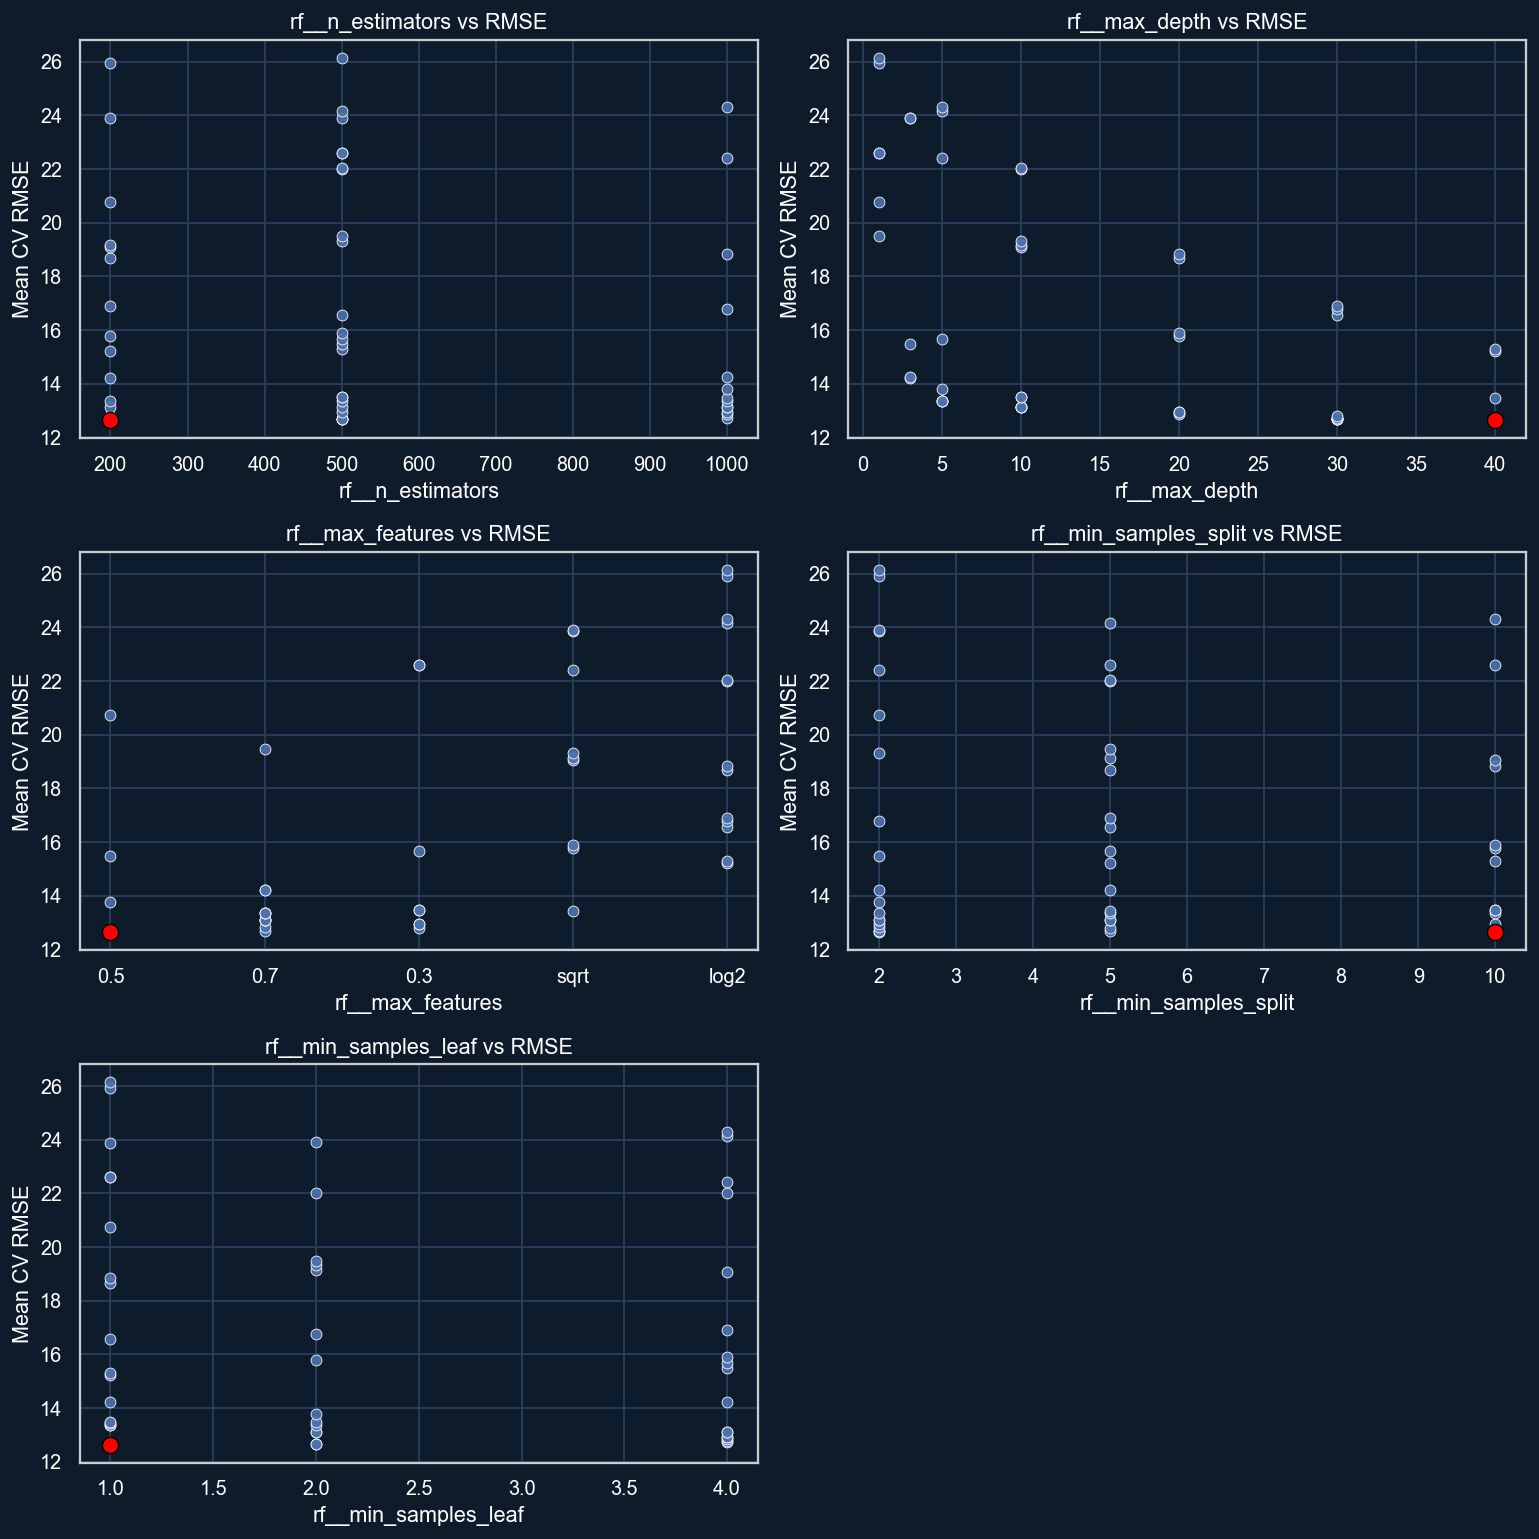

In [10]:
params = [p for p in search.param_distributions if f"param_{p}" in cv.columns]
n_params = len(params)
n_cols = 2
n_rows = math.ceil(n_params / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), dpi=130)
axes = axes.flatten()  

for i, p in enumerate(params):
    col = f"param_{p}"
    x = cv[col].astype(str) if cv[col].dtype == "O" else pd.to_numeric(cv[col])
    
    ax = axes[i]
    ax.scatter(x, cv["mean_rmse"], alpha=0.9, edgecolors='white', linewidths=0.5)
    # Highlight the lowest-RMSE point for this parameter in red
    ax.scatter(x.iloc[0], cv["mean_rmse"].iloc[0],
               s=80, color='red', edgecolors='black', linewidths=0.8, zorder=3)  # <-- add this
    ax.set_xlabel(p)
    ax.set_ylabel("Mean CV RMSE")
    ax.set_title(f"{p} vs RMSE")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

What we can notice from here:
- The best RMSE is 12.6376 at (200 trees, depth=40, max_features=0.5, min_split=10, min_leaf=1).
- Top 5 are within 0.0372 RMSE (≈0.29%) which is almost a practical tie.
- Deep trees perform much better than shallow ones.
- max_features fractions perform better than sqrt/log2 on this dataset.
- 200-500 trees are usually enough, 1000 yields no consistent improvement.
- Best node regularization settings are with min_leaf 1-2 and min_split 5-10.

Because the best RMSE often occurs at boundary values, we could push the grid search further for more optimization

## 3. Features Importance

Understanding which features drive model predictions is essential both for interpretability and for validating modeling choices. We will first examine feature importance as reported by the native RandomForest implementation in scikit-learn, followed by a more detailed analysis using SHAP values. This combined approach allows us to compare global importance scores with local, instance-level explanations, providing a more comprehensive view of how features influence predictions.

### 3.1. Native Scikit Learn

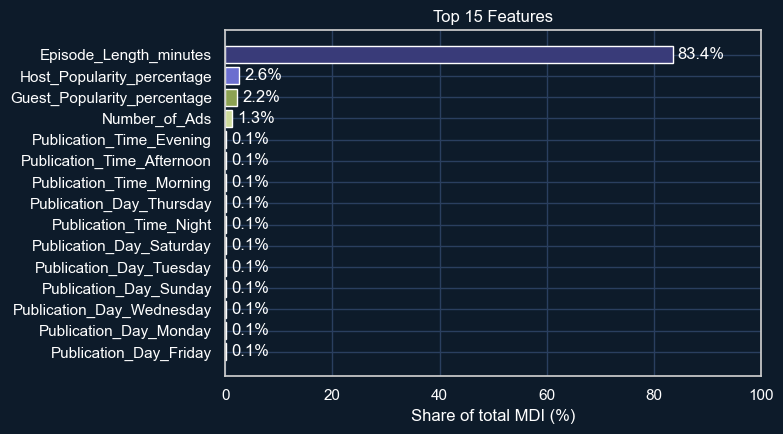

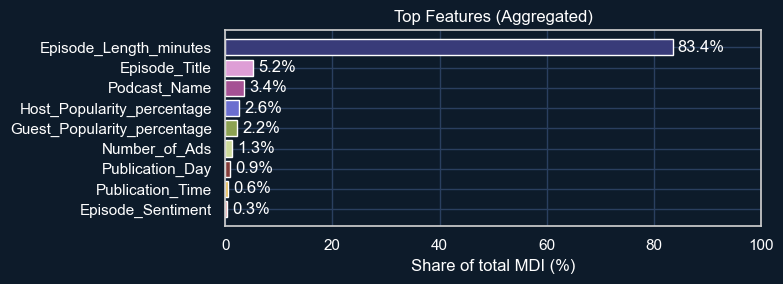

In [11]:
prep = pre.named_steps["prep"] if hasattr(pre, "named_steps") else pre
names = pd.Index(prep.get_feature_names_out())

imp = (pd.DataFrame({"feature": names, "importance": model.feature_importances_})
         .sort_values("importance", ascending=False)
         .reset_index(drop=True))

imp["parent"] = [parent_of(f, X_cat, X_num) for f in imp["feature"]]
agg_parent_imp = (imp.dropna(subset=["parent"])
                    .groupby("parent", as_index=False)["importance"].sum()
                    .sort_values("importance", ascending=False))

# Build one color map from ALL parents (numeric + categorical)
parents_all = list(dict.fromkeys(
    pd.concat([imp["parent"].dropna(), agg_parent_imp["parent"].dropna()], ignore_index=True)
))
parent_colors = make_color_map(parents_all, cmap="tab20b") 

# Detailed features: color by the parent column (so OHE shares parent color; nums keep their own)
barh_percent(imp, "feature", "importance",
             title="Top 15 Features", top_n=15,
             cmap="tab20", color_map=parent_colors, color_by="parent")
plt.show()

# Aggregated parents: color by the parent name itself
barh_percent(agg_parent_imp, "parent", "importance",
             title="Top Features (Aggregated)", top_n=15,
             cmap="tab20b", color_map=parent_colors)  # color_by defaults to x_col
plt.show()


Because scikit-learn’s RandomForestRegressor does not natively handle categorical variables, we applied one-hot encoding in preprocessing. For interpretability, we then aggregated the model’s Mean Decrease in Impurity (MDI) importances by summing each feature’s one-hot dummies back to its parent feature. As observed in the [EDA Notebook](1_Podcast_EDA.ipynb), the *Episode Length* is extremely valuable for our model, contributing to 83.4% of the total MDI. 

### 3.2 SHAP Values

Because MDI can favor continuous or high-cardinality splits and dilute importance among correlated features, we complement it with SHAP for more robust, local attributions. In particular, SHAP will quantify both the magnitude and direction of each feature’s effect on predictions and surface interaction patterns that MDI cannot. We will also compare the global SHAP summary with the aggregated MDI ranking to verify consistency and highlight any discrepancies.

First, let's compute the SHAP values for every model, we will first focus on Random Forest anyway but we will return to them later.

In [12]:
shap_folder = os.path.join(result_folder, "Shap")
os.makedirs(shap_folder, exist_ok=True)

overwrite_explainer = False
N_BG = 250
N_SAMPLE = 1000
max_evals = 1024  

for model_name in models_names:
    shap_path = os.path.join(shap_folder, f"shap_{model_name}.joblib")

    if overwrite_explainer or not os.path.exists(shap_path):
        print(f"Running {model_name}")
        sv = compute_shap_payload(models,model_name, X, N_SAMPLE, X_num, X_cat,n_bg=N_BG, max_evals=max_evals) 
        joblib.dump(sv, shap_path, compress=3)
    else:
        print(f"Loading {model_name}")
        sv = joblib.load(shap_path)

Loading lgbm
Loading xgb
Loading cat
Loading rf
Loading nn
Loading enet
Loading knn
Loading svr
Loading hgb
Loading et
Loading ebm
Loading tab


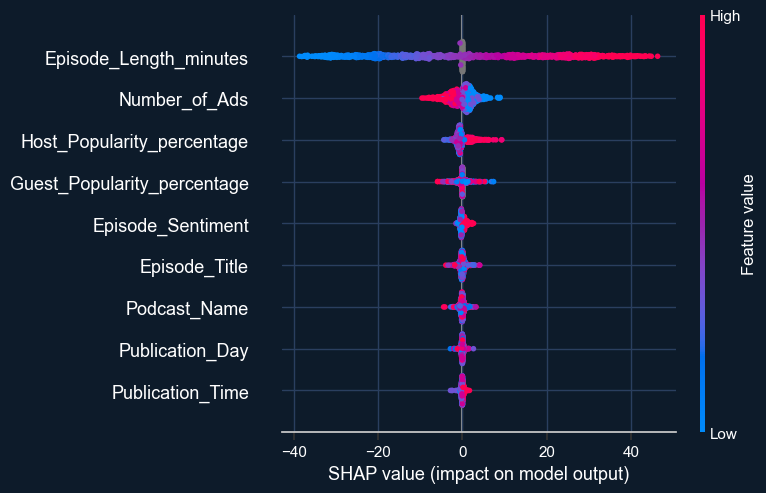

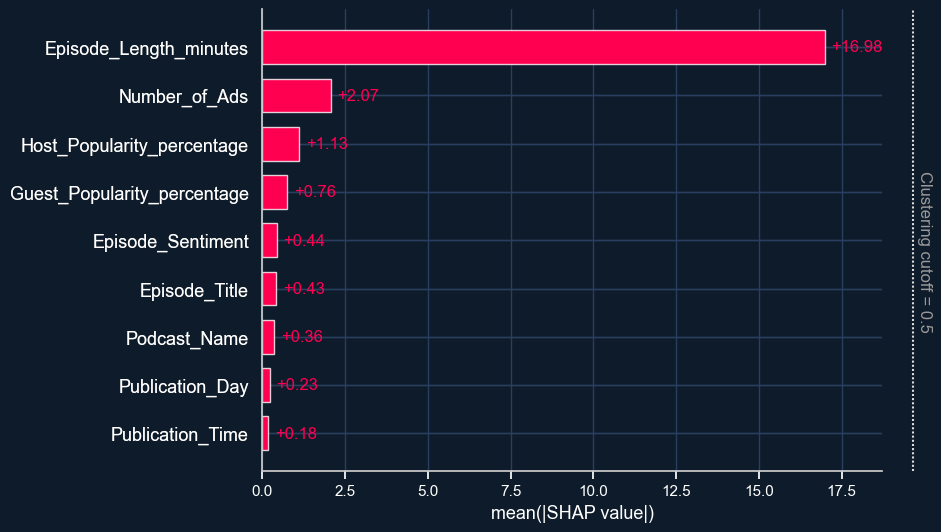

In [13]:
model_name = "rf"
shap_path = os.path.join(shap_folder, f"shap_{model_name}.joblib")
sv = joblib.load(shap_path)

shap.plots.beeswarm(sv, max_display=25, show=False)

ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color("white")
plt.tight_layout(); plt.show()
shap.plots.bar(sv, max_display=len(sv.feature_names))  

What we can learn from these insights :
- The *Episode_length_minutes* remains the dominant feature with SHAP values. 
- The *Publication Day* and *Time* remain minor
- What differs is the *Number of Ads* being way more important in the SHAP values while the *Episode Title* and *Podcast Name*, which were probably overrated by the MDI because of their High Cardinality (respectively 100 and 48 categories)

We need now to know in which direction now how these variables impact our target

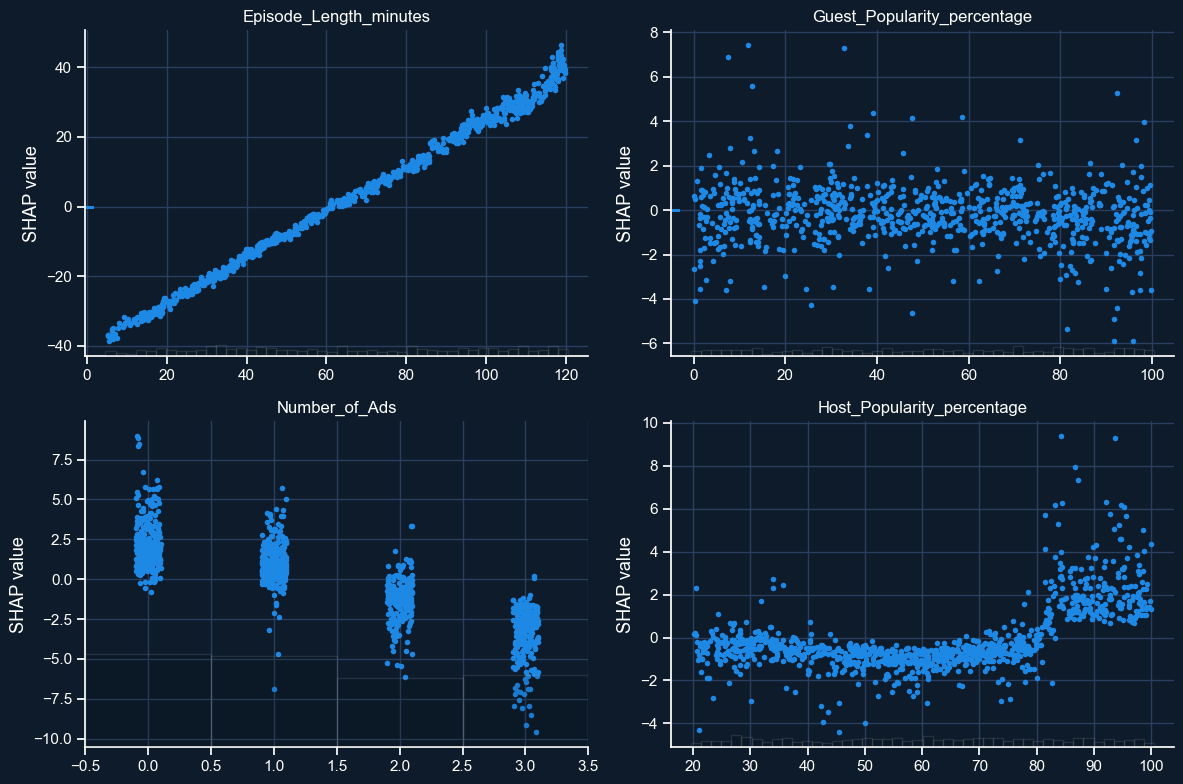

In [14]:
ncols = 2
nplots = len(X_num)
nrows = math.ceil(nplots / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4*nrows))
axes = axes.ravel() if nplots > 1 else [axes]

for i, col in enumerate(X_num):
    ax = axes[i]
    # draw SHAP dependence scatter for this feature on this subplot
    shap.plots.scatter(sv[:, col], ax=ax, show=False, axis_color="white")
    ax.set_title(str(col), color="white")
    ax.set_xlabel(f"", color="white")
    ax.set_ylabel("SHAP value", color="white")
    # make spines visible on dark bg
    for spine in ax.spines.values():
        spine.set_color("white")

# hide any unused panels if grid > number of features
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

- The *Episode Length Minutes* almost has a perfectly monotonic increase, with a relation linear with the target, with an average slope of +0.7 minutes of listening time per minute of episode length
- The *Guest popularity percentage* has almost no impact, with a noisy pattern, centered near 0 
- The *Number of Ads* has an unsurprising negative impact on the listening time, with each ads reducing in average from 1 to 2 minutes of listening time per ads
- The *Host Popularity percentage* seems to have a threshold at around 80%, above which the variable has a positive impact on the target.

####  Overview of SHAP values for every base model

After having analyzed the best performining base model in depth, let's take a look at all the other base models

In [28]:
imp_norm_cols   = []   # normalized importance per model (Series)
net_effect_cols = []   # mean signed SHAP per model (Series)
pos_rate_cols   = []   # fraction positive among all values (Series)
meta_rows       = []   # per-model metadata

for model_name in models_names:
    shap_path = os.path.join(shap_folder, f"shap_{model_name}.joblib")
    sv = joblib.load(shap_path)
    vals = np.asarray(sv.values)
    imp_abs_mean, net_effect, pos_rate, feat_names = summarize_explanation(sv)

    s_imp       = pd.Series(imp_abs_mean, index=feat_names, dtype=float, name=model_name)
    s_imp_norm  = normalize_series(s_imp) 
    s_net       = pd.Series(net_effect, index=feat_names, dtype=float, name=model_name)
    s_pos       = pd.Series(pos_rate, index=feat_names, dtype=float, name=model_name)

    imp_norm_cols.append(s_imp_norm)
    net_effect_cols.append(s_net)
    pos_rate_cols.append(s_pos)

# Cross-model panels (features x models)
imp_norm_df    = pd.concat(imp_norm_cols, axis=1).fillna(0.0)             # normalized importance
df_plot = imp_norm_df.T.iloc[::-1]
net_effect_df  = pd.concat(net_effect_cols, axis=1).fillna(0.0)           # signed mean
pos_rate_df    = pd.concat(pos_rate_cols, axis=1).replace({np.inf: np.nan, -np.inf: np.nan})

# Aggregated synthetic summary per feature
SHAP_agg = pd.DataFrame({
    "mean_importance": imp_norm_df.mean(axis=1),
    "std_importance":  imp_norm_df.std(axis=1),
    "mean_net_effect": net_effect_df.replace({np.inf: np.nan, -np.inf: np.nan}).mean(axis=1),
    "mean_pos_rate":   pos_rate_df.mean(axis=1, skipna=True),
})
SHAP_agg["coefficient_of_variation"] = SHAP_agg["std_importance"] / SHAP_agg["mean_importance"].replace(0, np.nan)
SHAP_agg["rank_by_mean"] = SHAP_agg["mean_importance"].rank(ascending=False, method="dense")
SHAP_agg = SHAP_agg.sort_values("mean_importance", ascending=False)

SHAP_agg

,mean_importance,std_importance,mean_net_effect,mean_pos_rate,coefficient_of_variation,rank_by_mean
Episode_Length_minutes,0.759153,0.040308,1.489808,0.473250,0.053095,1.0
Number_of_Ads,0.088163,0.009237,-0.050494,0.551917,0.104770,2.0
Host_Popularity_percentage,0.044686,0.004285,-0.006613,0.344833,0.095892,3.0
Episode_Title,0.024431,0.010150,0.027569,0.499500,0.415434,4.0
Guest_Popularity_percentage,0.024170,0.027781,-0.068104,0.421083,1.149393,5.0
Podcast_Name,0.020633,0.007738,-0.002717,0.464000,0.375023,6.0
Episode_Sentiment,0.019378,0.002774,0.015539,0.359000,0.143142,7.0
Publication_Day,0.010764,0.005660,-0.002568,0.532583,0.525851,8.0
Publication_Time,0.008622,0.002175,-0.006784,0.451333,0.252248,9.0


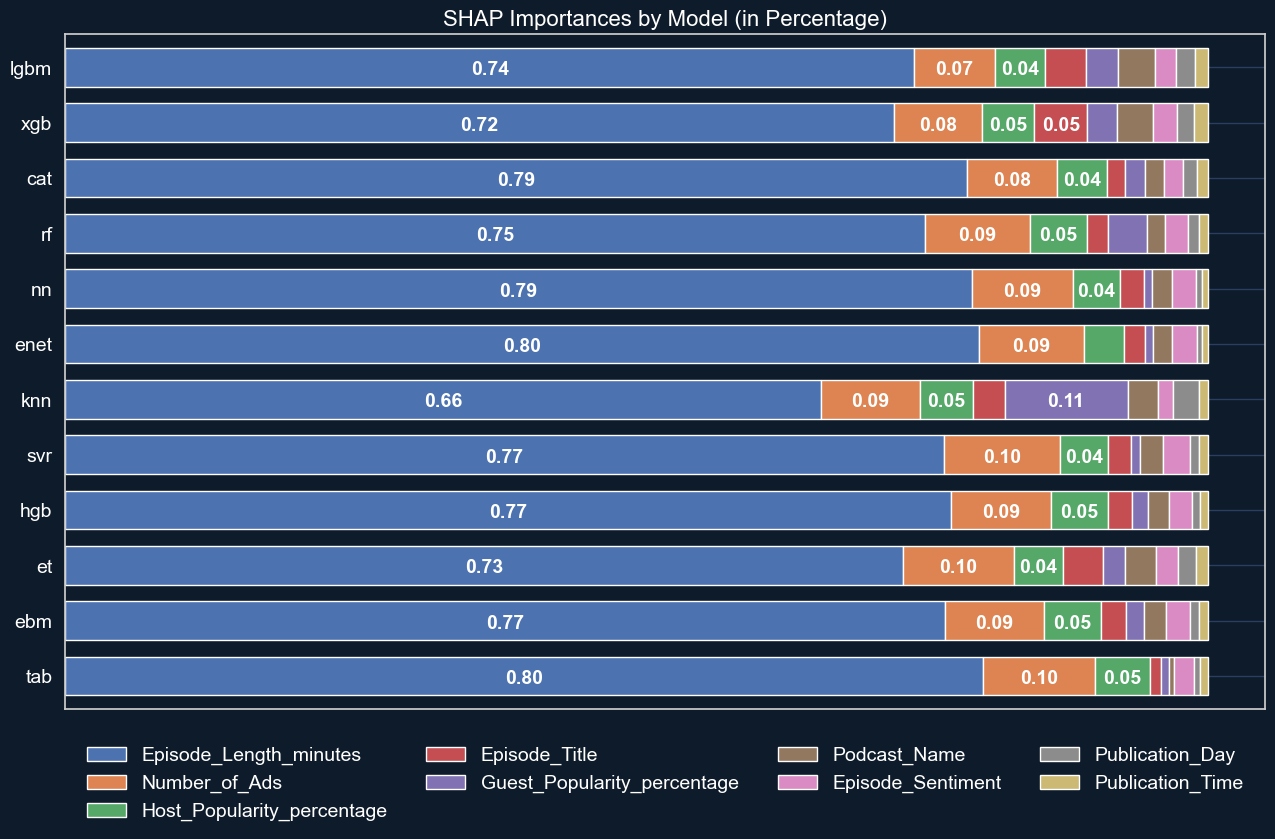

In [25]:
shap_bar_agg(df_plot)

Summary of the overview of all the base models : 
- All models rank *Episode_Length_minutes* as their dominant driver (from 66% to 80% of the SHAP values). Its mean net SHAP is clearly positive, consistent with an exposure effect: longer episodes allow more minutes to be accumulated. 
- Number_of_Ads is a stable #2 across models (from 7% to 10%), with a negative mean net effect. These two signals are the only ones that are both sizable and stable across model families.
- **Small but steady signal:** *Host_Popularity_percentage* sits around 4-5% importance in every model with low variability and a near zero/very slightly negative mean net effect. 
- **Unstable or model-sensitive signals:** *Guest_Popularity_percentage* shows the largest dispersion (high CV): it is modest in most models but spikes in KNN (10.8% vs 1%-3% elsewhere). This is typical of locality-based learners: distance metrics can overweight pockets where guest popularity co-varies with other features.

## 4. Cross-Validation Out-of-Fold Analysis

To further assess generalization beyond aggregate scores, we analyze the cross-validation out-of-fold (OOF) predictions. Plotting predicted values against the actual target provides a direct view of calibration: ideally, points should align along the diagonal, with systematic deviations highlighting bias or underfitting in certain ranges. Complementarily, examining residuals against predicted values allows us to detect heteroscedasticity, unmodeled patterns, or clusters where errors persist. 

These diagnostics help validate whether the model captures the underlying signal consistently or whether performance varies across different prediction intervals.

In [36]:
df_oof   = pd.read_csv(os.path.join(result_folder, "cv_oof.csv"))   
df_rmse  = pd.read_csv(os.path.join(result_folder, "cv_score.csv")) 

# --- Reconstruct folds to analyze per-fold stability ---
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
fold_idx = np.empty(len(df_oof), dtype=int)
for f, (_, val_idx) in enumerate(cv.split(df_train)):
    fold_idx[val_idx] = f
df_oof["fold"] = fold_idx
df_oof["y"] = df_train[target].reset_index(drop=True).astype(float)

# Residuals per model
for m in models_names + ["stack"]:
    df_oof[f"res_{m}"] = df_oof["y"] - df_oof[m]
    df_oof[f"abs_res_{m}"] = df_oof[f"res_{m}"].abs()

We are going to evaluate our **stack** model since it's the final model and the best performing one

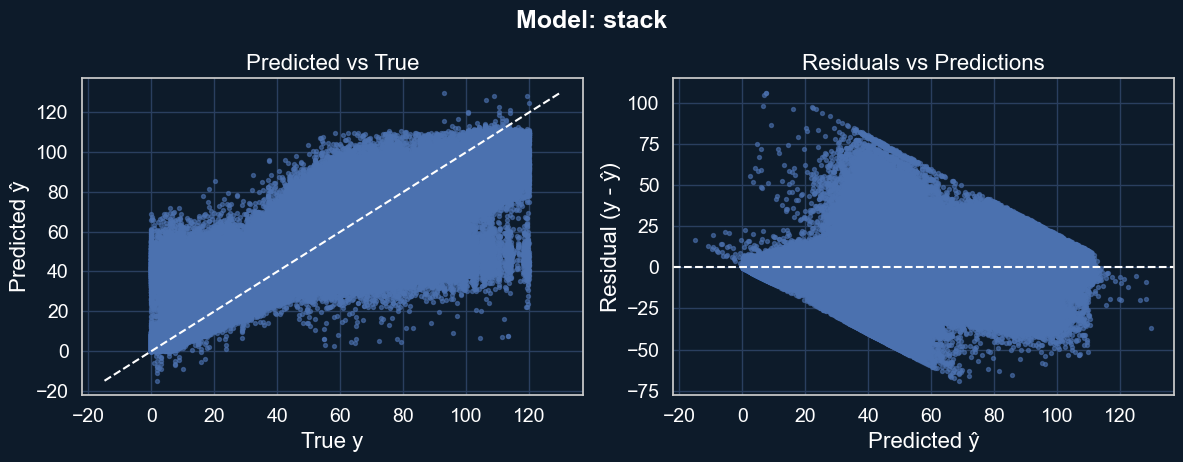

In [37]:
plot_residuals(df = df_oof, y = "y", m = "stack")

The OOF diagnostics highlight clear calibration issues. In the Predicted vs. True plot, the points are not symmetrically distributed around the diagonal: the model tends to overestimate small values and underestimate large ones, effectively compressing predictions toward the mean. This is confirmed in the Residuals vs. Predicted plot, where residuals systematically shift from positive at low predictions to negative at high predictions. Instead of being centered around zero with constant spread, the residuals form a wedge pattern, pointing to both bias across the target range and heteroscedasticity.

Since the *Episode Length* has shown such a big impact in all our previous analysis and is missing for around 11% of the data, it seems intuitive to compare the residual for the model depending on whether the *Episode Length* is missing or not

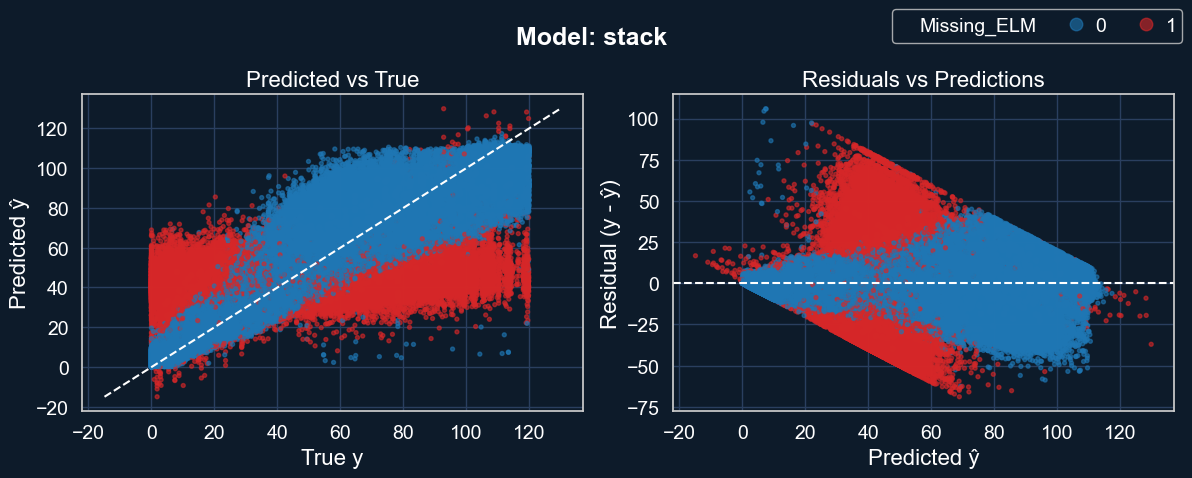

In [38]:
df_train["Missing_ELM"] = df_train["Episode_Length_minutes"].isna()
plot_residuals(df = df_oof, y = "y", m = "stack", color_col = df_train["Missing_ELM"],show_legend = True)

We stratified the OOF diagnostics by its availability: 
- When the variable is present (blue), predictions align more closely with the diagonal and residuals remain relatively centered, with only limited heteroscedasticity. 
- In contrast, when the variable is missing (red), the model collapses toward predicting the global mean, leading to systematic underestimation of high values and overestimation of low values. This confirms that the model relies heavily on Episode_Length_minutes and struggles to compensate for its absence

Let's analyze how is this behaviour for the single base models. Since many of them are highly correlated between each other as we've observed before, we are going to display only one per distinct "cluster"

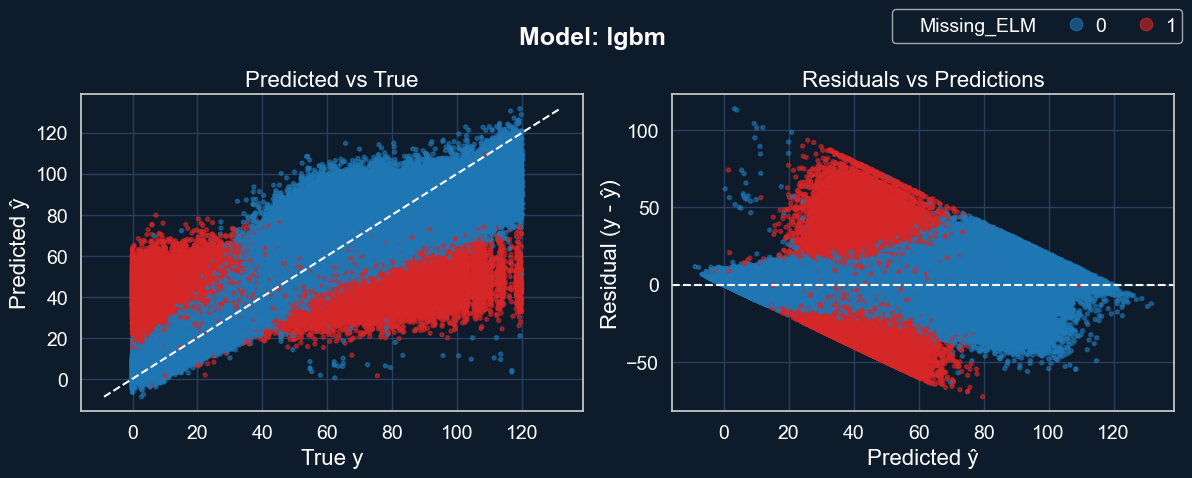

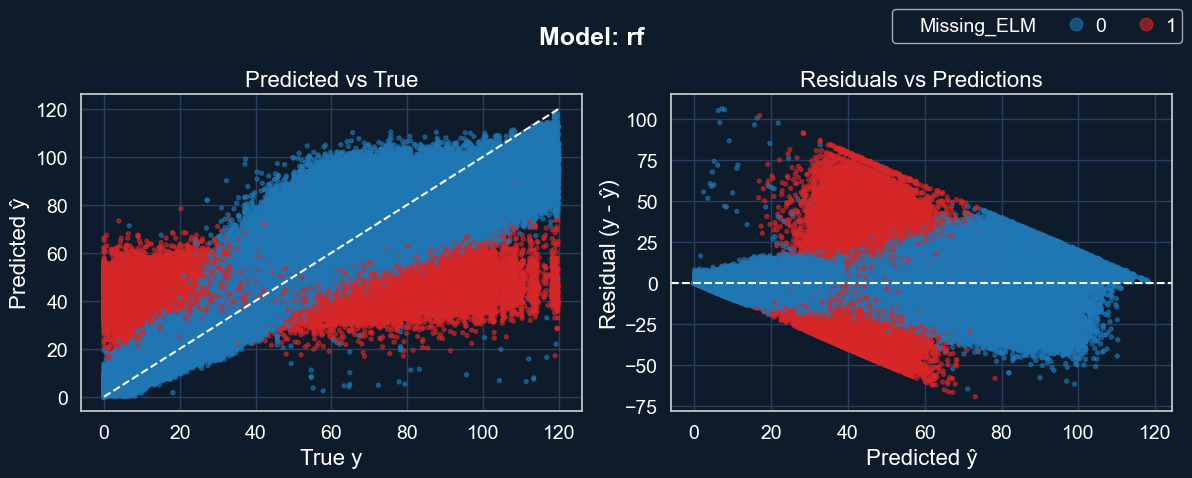

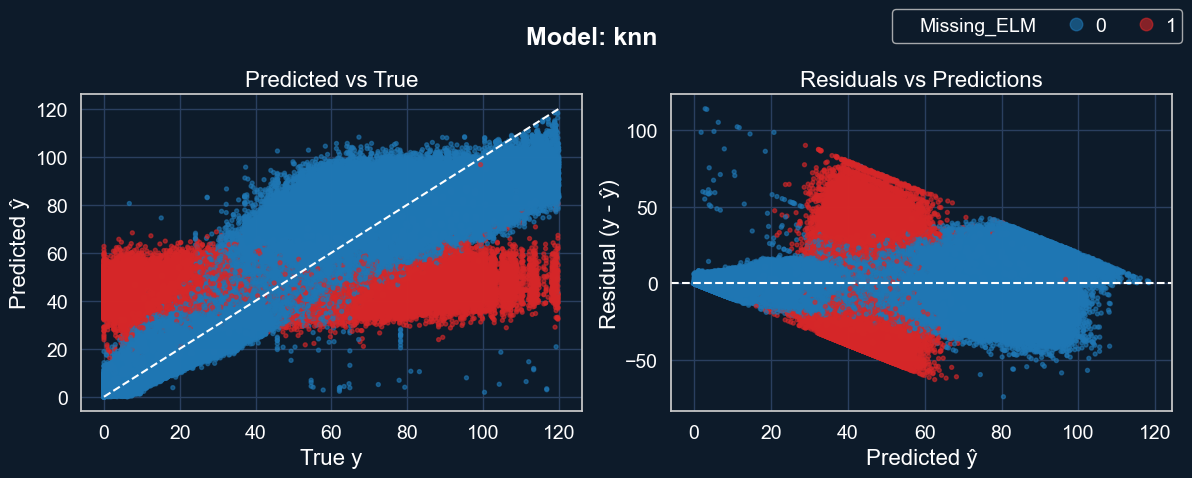

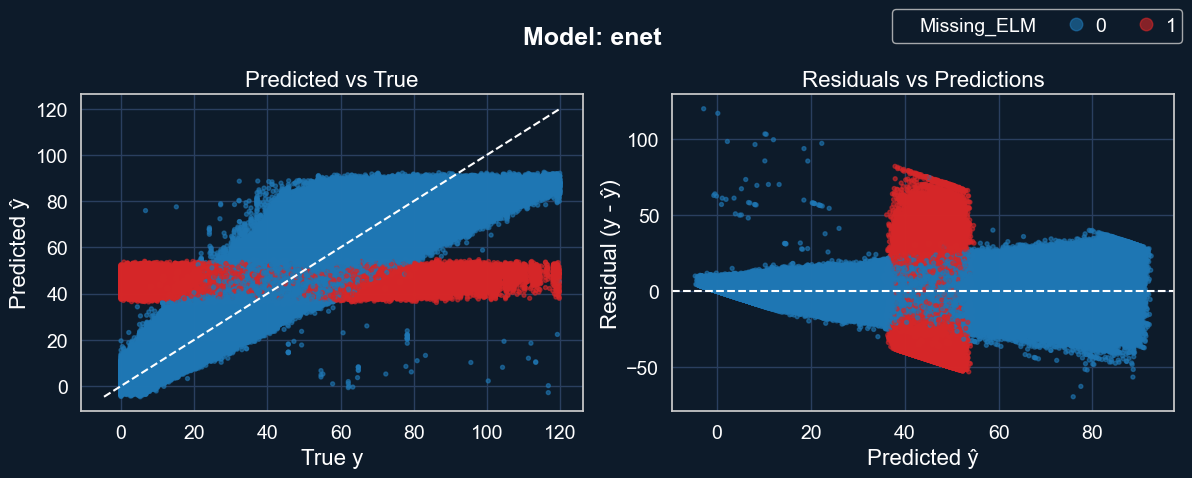

In [39]:
for m in ["lgbm","rf","knn","enet"]:
    plot_residuals(df = df_oof, y = "y", m = m, color_col = df_train["Missing_ELM"],show_legend = True)

The same global pattern appears across the base models. Random Forest and LightGBM behave most similarly to the final stack: when *Episode_Length_minutes is missing*, they still manage to extract a limited signal, resulting in a slight slope instead of a complete collapse toward the mean. 

By contrast, *Elastic Net* fails to account for these rows entirely, predicting values tightly centered around the average regardless of the target. *KNN* sits in between, capturing some structure but with weaker calibration and higher variance. Overall, this confirms that tree-based learners are better equipped to compensate for missing Episode_Length_minutes, while linear and distance-based methods struggle to generalize in its absence.

In [45]:
r2_noELM = []
r2_ELM = []
rmse_noELM = []
rmse_ELM = []

df_noELM = df_oof.loc[df_train["Missing_ELM"]]
df_ELM   = df_oof.loc[~df_train["Missing_ELM"]]

y_noELM = df_noELM["y"]
y_ELM = df_ELM["y"]

for m in list(df_rmse["model"]):
    model_noELM = df_noELM[m]
    model_ELM = df_ELM[m]
    
    r2_ELM.append(r2_score(y_ELM, model_ELM))
    r2_noELM.append(r2_score(y_noELM, model_noELM))
    rmse_ELM.append(root_mean_squared_error(y_ELM, model_ELM))
    rmse_noELM.append(root_mean_squared_error(y_noELM, model_noELM))

df_rmse["rmse_noELM"] = rmse_noELM
df_rmse["rmse_ELM"] = rmse_ELM
df_rmse["r2_noELM"] = r2_noELM
df_rmse["r2_ELM"] = r2_ELM
df_rmse = df_rmse.sort_values("rmse",ascending=False)

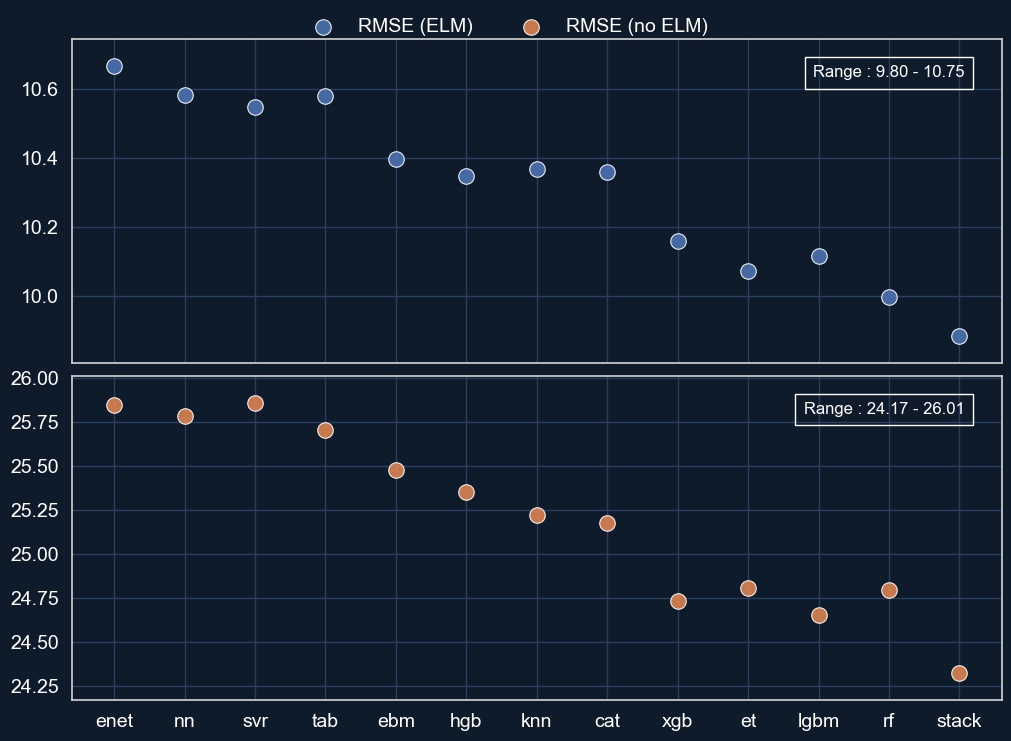

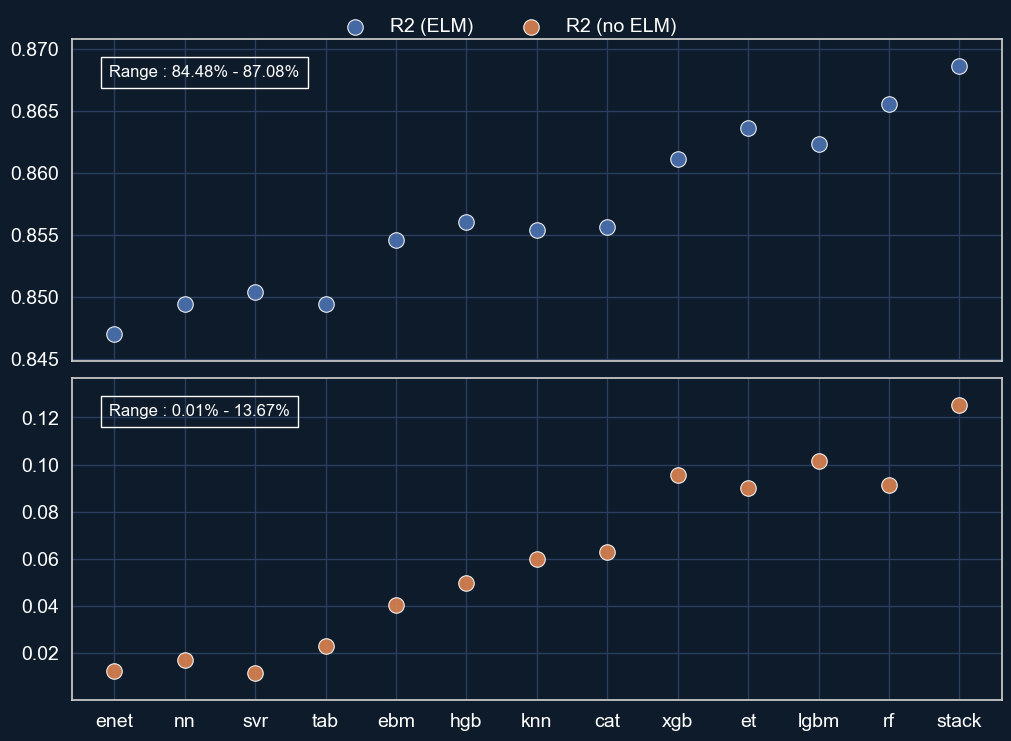

In [46]:
# Customize the placement of the annotation whether it's RMSE or R2
def add_text_score(ax_top, ax_bottom, score):
    for ax in (ax_top, ax_bottom):
        if score == "rmse": 
            add_text(ax, x = 0.96,y = 0.92, percent = False, ha = "right")
        else:  # r2
            add_text(ax, x = 0.04,y = 0.92, percent = True, ha = "left")
            
for score in ["rmse","r2"]:
    title = score.upper()
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, constrained_layout=True)
    pairs = [
        (ax_top,    f"{score}_ELM",   "C0", f"{title} (ELM)"),
        (ax_bottom, f"{score}_noELM", "C1", f"{title} (no ELM)"),
    ]
    handles = []
    
    for ax, col, color, label in pairs:
        h = ax.scatter(
            df_rmse["model"], df_rmse[col],
            s=125, c=color, edgecolors="white", linewidths=0.8, alpha=0.9, label=label
        )
        handles.append(h)
        ax.margins(y=0.10)  

    add_text_score(ax_top, ax_bottom, score)
    fig.legend(
        handles, [h.get_label() for h in handles],
        loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05)
    )
    plt.show()

The gap between cases where *Episode_Length_minutes* (ELM) is available and where it is missing is striking. When the feature is present, models achieve an RMSE around 10 and an R² close to 87%. In contrast, when it is absent, the RMSE jumps to ~25 and R² collapses, in some cases approaching zero.

Linear models such as Elastic Net illustrate this clearly, with an R² of only 0.01%, essentially performing no better than predicting the mean. 

By comparison, the stacked model still reaches an R² of 13.67% without Episode_Length_minutes, showing that it can capture a weak signal from secondary features, though its explanatory power remains small relative to the 87.08% achieved when the key feature is present.

# Conclusion

This project illustrates the end-to-end workflow of applied regression modeling, from exploratory analysis and feature engineering to benchmarking, interpretability, and error diagnostics. Across experiments, *Episode_Length_minutes* consistently dominated: when present, models reached strong performances (RMSE around 10, R² around 87%), while its absence caused performance to collapse. Tree based learners such as Random Forest and LightGBM retained some signal, whereas linear methods like Elastic Net essentially defaulted to the mean.

The final stacking regressor achieved the best overall performance by combining complementary base learners and proved more robust when key information was missing. Still, residual analyses showed calibration issues, with regression toward the mean and heteroscedastic errors, underlining the need for evaluation beyond aggregate scores.

This work demonstrates proficiency in structuring a modeling pipeline, applying interpretability techniques (MDI, SHAP), critically analyzing cross-validation behavior, and weighing trade-offs between complexity, interpretability, and generalization.

To further improve RMSE, future steps could focus on engineered proxies for Episode_Length_minutes, enriched temporal or semantic features, and more diverse ensembles. Fine-tuned hyperparameters and calibration methods could also address the systematic biases seen in residuals.